# Binary Classification

This is a basic example in which we learn to ground unary predicate $A$ that is defined in the space of $[0,1]^2$.

We define the predicate $A$ to apply to points that are close to the middle point $c=(.5,.5)$.In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on their euclidian distance to $c$. We then define two facts for the predicate $A$. For all points the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to.

In [43]:
import logging; logging.basicConfig(level=logging.INFO)
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

Sample random data from $[0,1]^2$. Our groundtruth positive training data for $A$ is close to the center (.5,.5). All other data is considered as negative examples.

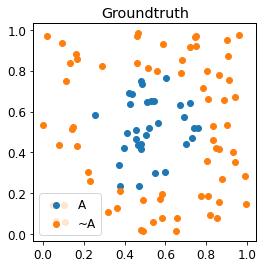

In [44]:
batch_size=64
nr_samples = 100
nr_samples_train = 50

data = np.random.uniform([0,0],[1,1],(nr_samples,2))
t_data = torch.tensor(data)
labels = np.sum(np.square(data-[.5,.5]),axis=1)<.09
t_labels = torch.tensor(labels)

# 50 examples for training; 50 examples for testing
ds_train = TensorDataset(t_data[:nr_samples_train],t_labels[:nr_samples_train])
dl_train = DataLoader(ds_train, batch_size=batch_size)
ds_test = TensorDataset(t_data[nr_samples_train:],t_labels[nr_samples_train:])
dl_test = DataLoader(ds_test, batch_size=batch_size)

plt.figure(figsize=(4,4))
plt.scatter(data[labels][:,0],data[labels][:,1],label='A')
plt.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
plt.title("Groundtruth")
plt.legend()
plt.show()


Define the predicate $A$. $A$ has arity 1 (single argument). The dimension of the argument is 2 (since the domain is $[0,1]^2$).

In [45]:
A = ltn.Predicate.MLP([2],hidden_layer_sizes=(16,16))

Import some operators to write the axioms.

In [46]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{data\_A}$, $A$ should be true. For all points in $\mathrm{data\_not\_A}$, $A$ is not true. 

In [47]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2)

def axioms(data, labels):
    x_A = ltn.variable("x_A",data[labels])
    x_not_A = ltn.variable("x_not_A",data[torch.logical_not(labels)])
    axioms = [
        Forall(x_A, A(x_A)),
        Forall(x_not_A, Not(A(x_not_A)))
    ]
    axioms = torch.stack(axioms)
    sat_level = formula_aggregator(axioms, axis=0)
    return sat_level, axioms

Initialize all layers and the static graph.

In [48]:
for _data, _labels in dl_test:
    print("Initial sat level %.5f"%axioms(_data, _labels)[0])
    break

Initial sat level 0.50127


Train on the knowledgebase.

In [49]:
#mean_metrics = tf.keras.metrics.Mean()

trainable_variables = A.parameters()
optimizer = Adam(trainable_variables, lr=0.001)
for epoch in range(2000):
    for _data, _labels in dl_train:
        optimizer.zero_grad()
        sat = axioms(_data,_labels)[0]
        loss = 1.- sat
        loss.backward()
        optimizer.step()
    if epoch%100 == 0:
        #mean_metrics.reset_states()
        with torch.no_grad():
            test_sats = []
            for _data, _labels in dl_test:
                #mean_metrics(axioms(_data, _labels)[0])
                test_sats.append(axioms(_data,_labels)[0])
        print("Epoch %d: (Test) Sat Level %.3f"%(epoch, torch.mean(torch.stack(test_sats)) ))
#mean_metrics.reset_states()
test_sats = []
for _data, _labels in dl_test:
    test_sats.append(axioms(_data,_labels)[0])
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, torch.mean(torch.stack(test_sats)) ))

Epoch 0: (Test) Sat Level 0.502
Epoch 100: (Test) Sat Level 0.493
Epoch 200: (Test) Sat Level 0.498
Epoch 300: (Test) Sat Level 0.560
Epoch 400: (Test) Sat Level 0.606
Epoch 500: (Test) Sat Level 0.669
Epoch 600: (Test) Sat Level 0.757
Epoch 700: (Test) Sat Level 0.811
Epoch 800: (Test) Sat Level 0.854
Epoch 900: (Test) Sat Level 0.887
Epoch 1000: (Test) Sat Level 0.911
Epoch 1100: (Test) Sat Level 0.929
Epoch 1200: (Test) Sat Level 0.945
Epoch 1300: (Test) Sat Level 0.958
Epoch 1400: (Test) Sat Level 0.969
Epoch 1500: (Test) Sat Level 0.975
Epoch 1600: (Test) Sat Level 0.980
Epoch 1700: (Test) Sat Level 0.984
Epoch 1800: (Test) Sat Level 0.987
Epoch 1900: (Test) Sat Level 0.988
Training finished at Epoch 1999 with Sat Level 0.990


The following queries the database on training data and test data. Vizualisation show the extent of generalization.

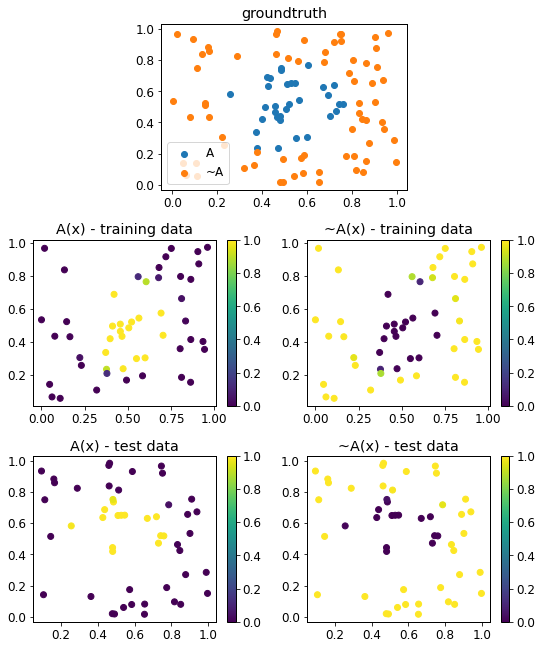

In [50]:
fig = plt.figure(figsize=(9, 11))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((3,8),(0,2),colspan=4)
ax.set_title("groundtruth")
ax.scatter(data[labels][:,0],data[labels][:,1],label='A')
ax.scatter(data[np.logical_not(labels)][:,0],data[np.logical_not(labels)][:,1],label='~A')
ax.legend()

# Training data
x = ltn.variable("x",t_data[:nr_samples_train])
fig.add_subplot(3, 2, 3)
result=A(x)
plt.title("A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.detach().numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 4)
result=Not(A(x))
plt.title("~A(x) - training data")
plt.scatter(data[:nr_samples_train,0],data[:nr_samples_train,1],c=result.detach().numpy().squeeze())
plt.colorbar()

# Test data
x = ltn.variable("x",t_data[nr_samples_train:])
fig.add_subplot(3, 2, 5)

result=A(x)
plt.title("A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.detach().numpy().squeeze())
plt.colorbar()

fig.add_subplot(3, 2, 6)
result=Not(A(x))
plt.title("~A(x) - test data")
plt.scatter(data[nr_samples_train:,0],data[nr_samples_train:,1],c=result.detach().numpy().squeeze())
plt.colorbar()
plt.savefig("ex_binary_testing.pdf")
plt.show()